# Part 1: Goal and Data Pre

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import torch.utils.data as data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

trainset = datasets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform = transforms.ToTensor())

x_train = (trainset.data/255 )
y_train = trainset.targets

x_test = (testset.data /255)
y_test = testset.targets

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

train_dataset = data.TensorDataset(x_train, y_train)

batch_size = 64
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

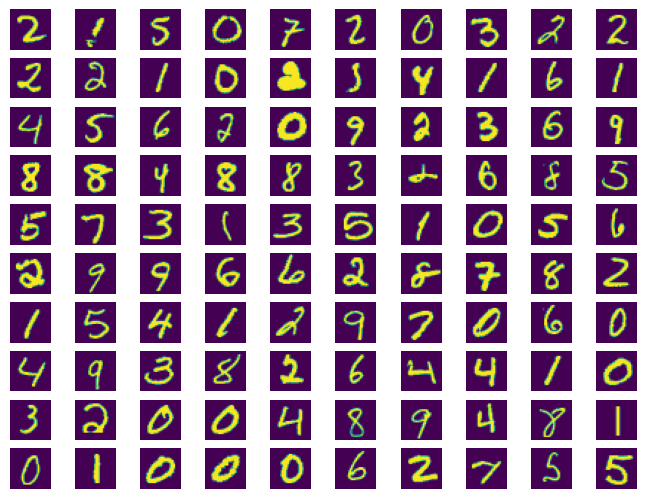

In [21]:
def generate_plot( images, kcount ):
    images = images.reshape( -1, 28, 28 ) * 255
    images = images.to("cpu").numpy().astype(np.uint8)

    fig, axarr = plt.subplots(kcount, kcount)

    k = 0
    for i in range(kcount):
        for j in range(kcount):
            axarr[i,j].imshow( images[k], vmin=0)
            axarr[i,j].axis('off')
            k += 1
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()
    return


k_count = 10
indices = random.sample( [ i for i in range(60000) ], k = k_count*k_count )
generate_plot(x_train[indices], k_count)

# Part 2: The VAE Architecture

In [10]:
class MNISTEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear( in_features = 784, out_features = 256 )
    self.layer_2 = torch.nn.Linear( in_features = 256, out_features = 256 )
    self.layer_3 = torch.nn.Linear( in_features = 256, out_features = 256 )

    self.means = torch.nn.Linear( in_features = 256, out_features = 2 )
    self.log_variances = torch.nn.Linear( in_features = 256, out_features = 2 )

  def forward(self, input_tensor):
    flattened = nn.Flatten()( input_tensor )

    hidden_nodes = self.layer_1( flattened )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    hidden_nodes = self.layer_2( hidden_nodes )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    hidden_nodes = self.layer_3( hidden_nodes )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    z_means = self.means( hidden_nodes )
    z_logvars = self.log_variances( hidden_nodes )

    return z_means, z_logvars

class MNISTDecoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = torch.nn.Linear( in_features = 2, out_features = 256 )
    self.layer_2 = torch.nn.Linear( in_features = 256, out_features = 256 )
    self.layer_3 = torch.nn.Linear( in_features = 256, out_features = 256 )

    self.layer_4 = torch.nn.Linear( in_features = 256, out_features = 784 )

  def forward(self, input_tensor):

    hidden_nodes = self.layer_1( input_tensor )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    hidden_nodes = self.layer_2( hidden_nodes )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    hidden_nodes = self.layer_3( hidden_nodes )
    hidden_nodes = torch.nn.ReLU()( hidden_nodes )

    pixel_values = self.layer_4( hidden_nodes )
    pixel_values = torch.nn.Sigmoid()( pixel_values )

    pixel_values = torch.reshape( pixel_values, (-1, 28, 28) )
    return pixel_values

Output of an UNTRAINED decoder:


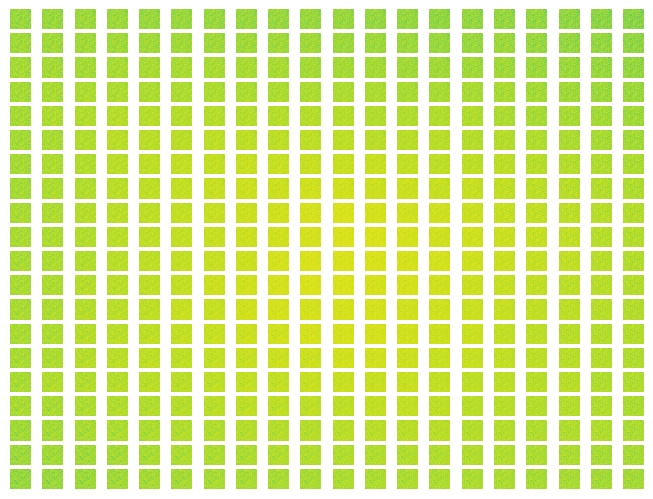

In [30]:
def generate_interpolation( bound, k, decoder ):
    # Generate a k*k grid of 2D points in the latent space
    delta = 2*bound / (k-1)
    z_values = [ -bound + i*delta for i in range( k ) ]

    values = torch.zeros( [k*k, 2] ).to(device) # Ensure tensor is on the correct device

    for i in range(k):
        for j in range(k):
            values[i*k + j, 0] = z_values[i]
            values[i*k + j, 1] = z_values[j]

    # Generate images with the decoder
    with torch.no_grad():
        # Move to CPU for numpy and matplotlib operations
        generated_images = decoder( values )

    return generated_images

# Instantiate an untrained model
un_encoder = MNISTEncoder().to(device)
un_decoder = MNISTDecoder().to(device)

# Visualize the output
print("Output of an UNTRAINED decoder:")
generated_images = generate_interpolation( 3, 20, un_decoder )
generate_plot( generated_images, 20 )

In [15]:
generated_images[0]

tensor([[0.5487, 0.4959, 0.4905, 0.4417, 0.5005, 0.4435, 0.5761, 0.4667, 0.5175,
         0.5666, 0.5185, 0.4778, 0.5902, 0.5063, 0.4744, 0.4904, 0.5090, 0.5004,
         0.4546, 0.5216, 0.5129, 0.5380, 0.4603, 0.5053, 0.5044, 0.5150, 0.4939,
         0.4411],
        [0.4921, 0.5053, 0.5320, 0.5101, 0.4901, 0.5160, 0.4753, 0.5313, 0.4381,
         0.5135, 0.4588, 0.5299, 0.5089, 0.4696, 0.4765, 0.5379, 0.5032, 0.5137,
         0.4874, 0.5245, 0.5105, 0.5642, 0.4920, 0.4790, 0.4578, 0.4911, 0.5178,
         0.5446],
        [0.5616, 0.5002, 0.5246, 0.4695, 0.5322, 0.5226, 0.4170, 0.5058, 0.4427,
         0.4816, 0.5134, 0.5520, 0.5094, 0.5344, 0.5327, 0.4753, 0.4952, 0.5254,
         0.5195, 0.5202, 0.4547, 0.4917, 0.5051, 0.5221, 0.4819, 0.4732, 0.5189,
         0.4385],
        [0.5824, 0.4649, 0.5140, 0.4546, 0.5326, 0.5234, 0.5034, 0.5164, 0.5459,
         0.3944, 0.4742, 0.4765, 0.5308, 0.4660, 0.4436, 0.5751, 0.5148, 0.4522,
         0.4860, 0.4815, 0.5021, 0.5247, 0.4690, 0.4564

In [12]:
def kl_divergence( z_means, z_logvars ):
    # kl_divergence_means punishes means that are far from 0
    kl_divergence_means = 0.5 * torch.mean( torch.square( z_means ) )

    # kl_divergence_variance punishes variances that are far from 1
    # The formula is 0.5 * (sigma^2 - log(sigma^2) - 1)
    kl_divergence_variance = 0.5 * torch.mean( torch.exp( z_logvars ) - z_logvars - 1 )

    return kl_divergence_means + kl_divergence_variance

Encoded 10000 test images with the untrained encoder.


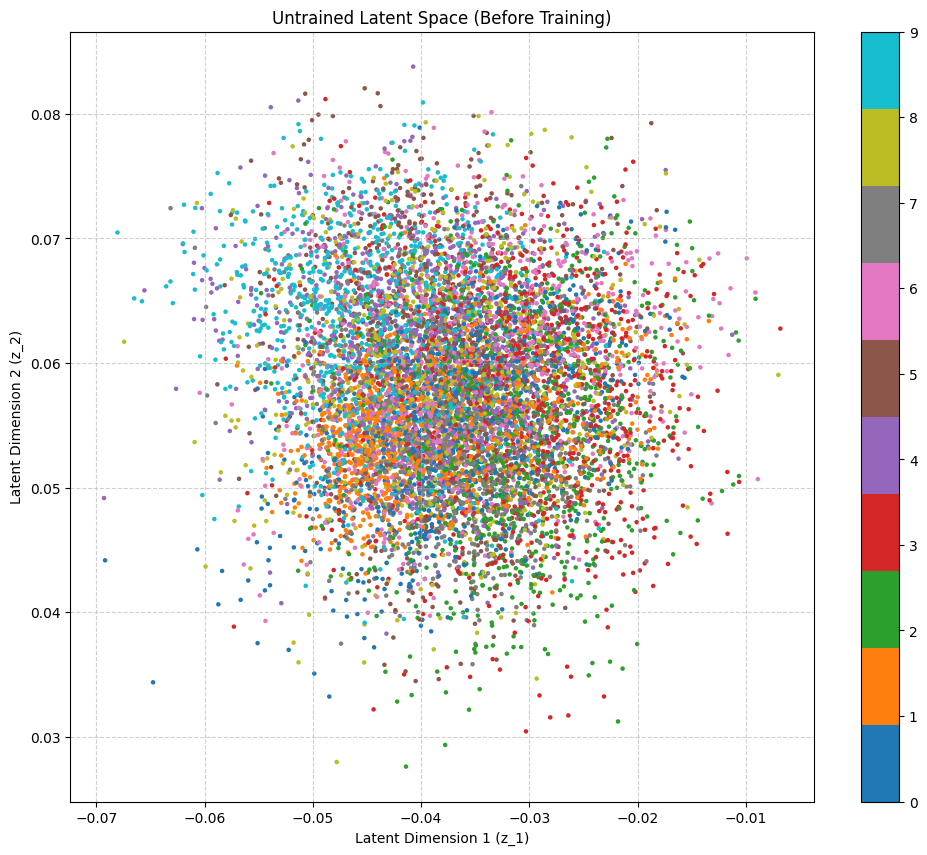

In [13]:
# Create a new, untrained encoder instance
un_encoder_viz = MNISTEncoder().to(device)
un_encoder_viz.eval() # Set to evaluation mode

# We need a DataLoader for the test set
test_loader_viz = data.DataLoader(dataset=testset, batch_size=512, shuffle=False)

all_z_means_un = []
all_labels_un = []

with torch.no_grad():
    for x_batch, y_batch in test_loader_viz:
        x_batch = x_batch.to(device)

        # Pass data through the UNTRAINED encoder
        z_means, _ = un_encoder_viz(x_batch)

        all_z_means_un.append(z_means.cpu())
        all_labels_un.append(y_batch.cpu())

# Concatenate all batches
all_z_means_un = torch.cat(all_z_means_un, dim=0)
all_labels_un = torch.cat(all_labels_un, dim=0)

print(f"Encoded {len(all_labels_un)} test images with the untrained encoder.")

# Plot the 2D latent space
plt.figure(figsize=(12, 10))
scatter = plt.scatter(all_z_means_un[:, 0], all_z_means_un[:, 1], c=all_labels_un, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Latent Dimension 1 (z_1)")
plt.ylabel("Latent Dimension 2 (z_2)")
plt.title("Untrained Latent Space (Before Training)") # Key difference in title
plt.show()

# Part 3: Experiment

## Draft 1: MSE Loss

In [14]:
# Re-initialize models for each experiment
encoder_d1 = MNISTEncoder().to(device)
decoder_d1 = MNISTDecoder().to(device)

# Define the optimizer
optimizer = optim.Adam( list( encoder_d1.parameters() ) + list(  decoder_d1.parameters() ) , lr = 0.001 )

print("Starting Draft 1 (MSE Loss)")

for epoch in range(10): # Train for 10 epochs
  total_loss = 0
  for x_batch, y_batch in train_loader:

    # 1. Encode: (batch, 28, 28) -> (batch, 2) means + (batch, 2) logvars
    z_means, z_logvars = encoder_d1( x_batch )

    # 2. Reparameterization Trick
    # z_noisy = z_means + std * noise
    std = torch.exp( 0.5 * z_logvars )
    noise = torch.randn_like( std ) # N(0, 1) noise
    z_noisy = z_means + noise * std # The "noisy encoding"

    # 3. Decode: (batch, 2) -> (batch, 28, 28)
    decoded_images = decoder_d1( z_noisy )

    # 4. Calculate Loss
    # Loss 1: Reconstruction Loss (Draft 1 uses MSE)
    reconstruction_loss = torch.mean( torch.square( x_batch - decoded_images ) )

    # Loss 2: KL Divergence (regularizes the latent space)
    kl_loss = kl_divergence( z_means, z_logvars )

    # Total Loss
    beta = 1.0 # Weight for the KL term
    loss = reconstruction_loss + beta * kl_loss

    # 5. Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len( train_loader )}")

print("Draft 1 Training Complete.")

Starting Draft 1 (MSE Loss)
Epoch 1, Avg Loss: 0.06911067172948486
Epoch 2, Avg Loss: 0.06748165130249854
Epoch 3, Avg Loss: 0.06741916763582337
Epoch 4, Avg Loss: 0.06738681505039049
Epoch 5, Avg Loss: 0.0673498922565789
Epoch 6, Avg Loss: 0.06733439093443758
Epoch 7, Avg Loss: 0.06732059343616718
Epoch 8, Avg Loss: 0.06731083490717005
Epoch 9, Avg Loss: 0.06730441015158127
Epoch 10, Avg Loss: 0.06730106438416789
Draft 1 Training Complete.


Result for Draft 1 (MSE Loss):


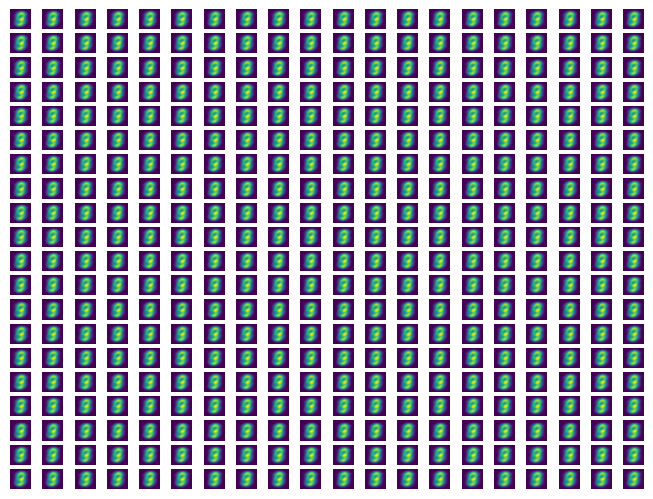

In [22]:
print("Result for Draft 1 (MSE Loss):")
generated_images = generate_interpolation( 3, 20, decoder_d1 )
generate_plot( generated_images, 20 )

In [18]:
generated_images[0].max()

tensor(0.5723, device='cuda:0')

## Draft 2: BCE Loss

In [23]:
# Re-initialize models
encoder_d2 = MNISTEncoder().to(device)
decoder_d2 = MNISTDecoder().to(device)

# Professor's code switches to SGD with a different learning rate
optimizer = optim.SGD( list( encoder_d2.parameters() ) + list(  decoder_d2.parameters() ) , lr = 0.1 )

# Define the BCE loss (manual version from professor's code)
def bce_loss( x_true, x_pred ):
    fudge_factor = 0.001 # To prevent log(0)
    # -p*log(q)
    term_1 = x_true * torch.log( x_pred + fudge_factor )
    # -(1-p)*log(1-q)
    term_2 = ( 1 - x_true ) * torch.log( 1 - x_pred + fudge_factor )

    # Return the mean of the negative log-likelihood
    return torch.mean( -1 * ( term_1 + term_2 ) )

beta = 0.01 # KL weight for Draft 2

print("Starting Draft 2 (BCE Loss)...")

for epoch in range(10):
  total_loss = 0
  for x_batch, y_batch in train_loader:

    # 1. Encode
    z_means, z_logvars = encoder_d2( x_batch )

    # 2. Reparameterization Trick
    std = torch.exp( 0.5 * z_logvars )
    noise = torch.randn_like( std )
    z_noisy = z_means + noise * std

    # 3. Decode
    decoded_images = decoder_d2( z_noisy )

    # 4. Calculate Loss
    # Loss 1: Reconstruction Loss (Draft 2 uses BCE)
    reconstruction_loss = bce_loss( x_batch, decoded_images )

    # Loss 2: KL Divergence
    kl_loss = kl_divergence( z_means, z_logvars )

    # Total Loss (note the beta)
    loss = reconstruction_loss + beta * kl_loss

    # 5. Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len( train_loader )}")

print("Draft 2 Training Complete.")

Starting Draft 2 (BCE Loss)...
Epoch 1, Avg Loss: 0.3992872277556706
Epoch 2, Avg Loss: 0.26403607841112464
Epoch 3, Avg Loss: 0.25972852082267756
Epoch 4, Avg Loss: 0.25763413033632837
Epoch 5, Avg Loss: 0.25614152688270947
Epoch 6, Avg Loss: 0.254198595230132
Epoch 7, Avg Loss: 0.2520189232695331
Epoch 8, Avg Loss: 0.25025027056238547
Epoch 9, Avg Loss: 0.24921873099069353
Epoch 10, Avg Loss: 0.24862853191427584
Draft 2 Training Complete.


Result for Draft 2 (BCE Loss):


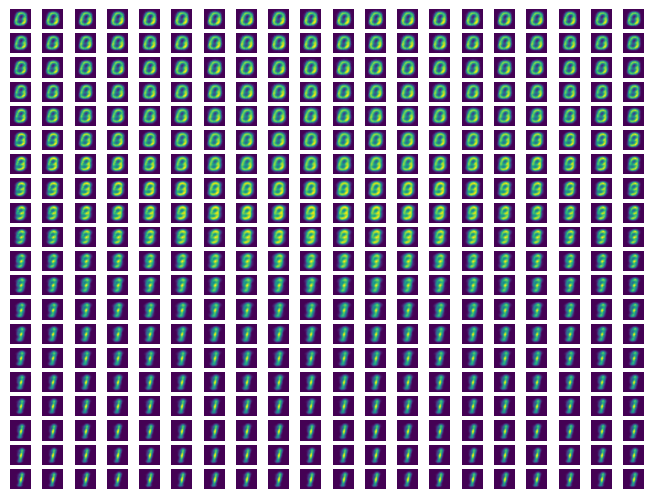

In [24]:
print("Result for Draft 2 (BCE Loss):")
generated_images = generate_interpolation( 3, 20, decoder_d2 )
generate_plot( generated_images, 20 )

## Draft 3: BCE Loss + Multiple Samples

In [25]:
# Re-initialize models
encoder_d3 = MNISTEncoder().to(device)
decoder_d3 = MNISTDecoder().to(device)

# Optimizer
optimizer = optim.SGD( list( encoder_d3.parameters() ) + list(  decoder_d3.parameters() ) , lr = 0.1 )

beta = 0.01 # KL weight
num_replications = 10 # Number of samples per image

print(f"Starting Draft 3 (BCE Loss + {num_replications} Samples)...")

for epoch in range(10):
  total_loss = 0
  for x_batch, y_batch in train_loader:

    optimizer.zero_grad()

    # 1. Encode (only once per batch)
    z_means, z_logvars = encoder_d3( x_batch )

    # Accumulate loss over all replications
    avg_loss = 0

    # Loop 10 times
    for replication in range(num_replications):

        # 2. Reparameterization Trick (new noise each time)
        std = torch.exp( 0.5 * z_logvars )
        noise = torch.randn_like( std )
        z_noisy = z_means + noise * std

        # 3. Decode
        decoded_images = decoder_d3( z_noisy )

        # 4. Calculate loss for this sample
        reconstruction_loss = bce_loss( x_batch, decoded_images )
        kl_loss = kl_divergence( z_means, z_logvars )

        # Accumulate the loss
        avg_loss += (reconstruction_loss + beta * kl_loss)

    # 5. Backpropagation (use the average loss)
    final_loss = avg_loss / num_replications
    final_loss.backward()
    optimizer.step()

    total_loss += final_loss.item()

  print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len( train_loader )}")

print("Draft 3 Training Complete.")

Starting Draft 3 (BCE Loss + 10 Samples)...
Epoch 1, Avg Loss: 0.4157578817753395
Epoch 2, Avg Loss: 0.2636230323296874
Epoch 3, Avg Loss: 0.2623727393588786
Epoch 4, Avg Loss: 0.26181853886669887
Epoch 5, Avg Loss: 0.26136804580180123
Epoch 6, Avg Loss: 0.26093764858904167
Epoch 7, Avg Loss: 0.26055865050124716
Epoch 8, Avg Loss: 0.2602065811152143
Epoch 9, Avg Loss: 0.2599172246004981
Epoch 10, Avg Loss: 0.2596777148846624
Draft 3 Training Complete.


Result for Draft 3 (BCE Loss + 10 Samples):


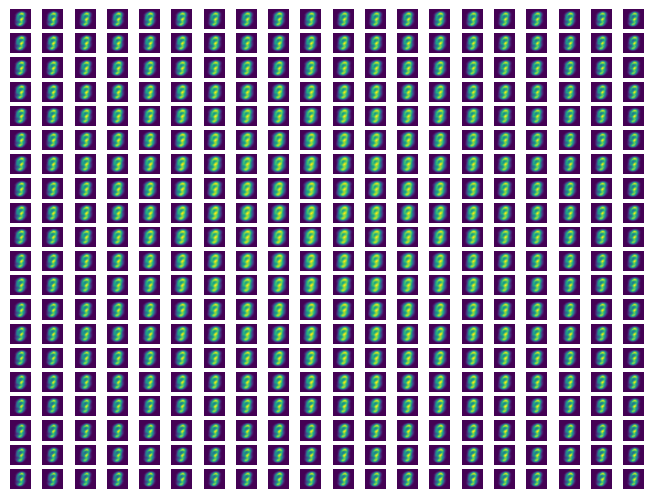

In [26]:
print("Result for Draft 3 (BCE Loss + 10 Samples):")
generated_images = generate_interpolation( 3, 20, decoder_d3 )
generate_plot( generated_images, 20 )

## Draft 4: using CNN

In [27]:
class MNISTConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28→14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14→7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # 7→7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 7 * 7, 2)
        self.fc_logvar = nn.Linear(128 * 7 * 7, 2)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class MNISTConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 128 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # 7→7
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14→28
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)
        x = self.decoder(x)
        return x




In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

In [29]:
encoder_d4 = MNISTConvEncoder().to(device)
decoder_d4 = MNISTConvDecoder().to(device)

# --- Loss helpers that match image shapes (N,1,28,28) ---
# Define the BCE loss (manual version from professor's code)
def bce_loss( x_true, x_pred ):
    fudge_factor = 0.001 # To prevent log(0)
    # -p*log(q)
    term_1 = x_true * torch.log( x_pred + fudge_factor )
    # -(1-p)*log(1-q)
    term_2 = ( 1 - x_true ) * torch.log( 1 - x_pred + fudge_factor )

    # Return the mean of the negative log-likelihood
    return torch.mean( -1 * ( term_1 + term_2 ) )

def kl_divergence(mu, logvar):
    # KL per batch (mean over batch)
    # 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar )
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl / mu.size(0)

# --- Optimizer ---
# You can keep SGD if you like, but Adam tends to be stabler for VAEs:
# optimizer = optim.SGD(list(encoder_d4.parameters()) + list(decoder_d4.parameters()), lr=0.1)
optimizer = optim.Adam(list(encoder_d4.parameters()) + list(decoder_d4.parameters()), lr=1e-3)

beta = 0.01           # KL weight
num_replications = 10 # Number of samples per image

print(f"Starting Draft 4 (BCE Loss + {num_replications} Samples) with Conv models...")

for epoch in range(10):
    encoder_d4.train()
    decoder_d4.train()

    total_loss = 0.0

    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)  # (N,1,28,28)

        optimizer.zero_grad()

        # 1) Encode once per batch
        z_means, z_logvars = encoder_d4(x_batch)

        # 2) Monte Carlo replicate (reparameterize each time)
        avg_loss = 0.0
        for _ in range(num_replications):
            std = torch.exp(0.5 * z_logvars)
            noise = torch.randn_like(std)
            z_noisy = z_means + noise * std

            # 3) Decode
            decoded_images = decoder_d4(z_noisy)  # (N,1,28,28)

            # 4) Loss for this replication
            recon_loss = bce_loss(x_batch, decoded_images)
            kl = kl_divergence(z_means, z_logvars)

            avg_loss += (recon_loss + beta * kl)

        # 5) Average over replications, backprop
        final_loss = avg_loss / num_replications
        final_loss.backward()
        optimizer.step()

        total_loss += final_loss.item()

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len(train_loader):.4f}")

print("Draft 4 Training Complete (Conv models).")

Starting Draft 4 (BCE Loss + 10 Samples) with Conv models...
Epoch 1, Avg Loss: 0.2510
Epoch 2, Avg Loss: 0.2345
Epoch 3, Avg Loss: 0.2322
Epoch 4, Avg Loss: 0.2309
Epoch 5, Avg Loss: 0.2300
Epoch 6, Avg Loss: 0.2293
Epoch 7, Avg Loss: 0.2287
Epoch 8, Avg Loss: 0.2282
Epoch 9, Avg Loss: 0.2278
Epoch 10, Avg Loss: 0.2274
Draft 4 Training Complete (Conv models).


Result for Draft 4 (BCE Loss + 10 Samples):


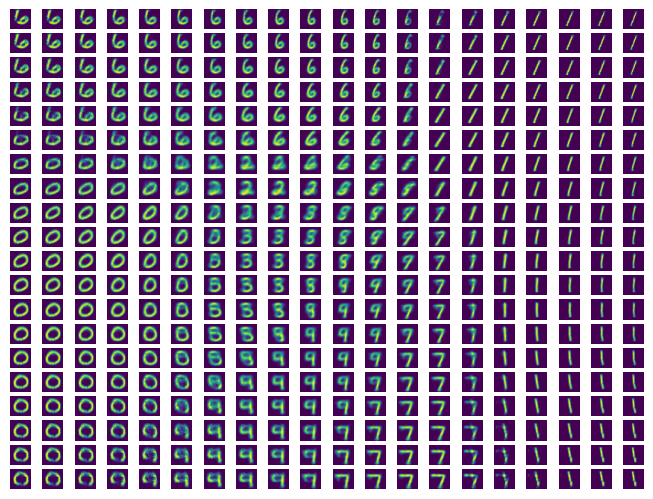

In [ ]:
print("Result for Draft 4 (BCE Loss + 10 Samples):")
generated_images = generate_interpolation( 3, 20, decoder_d4 )
generate_plot( generated_images, 20 )

# Part 6: Wrap-up and Discussion

## Why do some decoded images not look like digits?

The KL divergence loss encourages the latent space to be smooth and continuous. This means the space between the encoding for a "7" and the encoding for an "8" must also be filled.

The model doesn't understand the concept of digits; it only understands pixel patterns. The image decoded from a point halfway between a "7" and an "8" is simply an interpolation of the pixel values of those two digits, which doesn't have to correspond to a meaningful number.

# Part 7: Visualizing the Latent Space

Encoded 10000 test images.


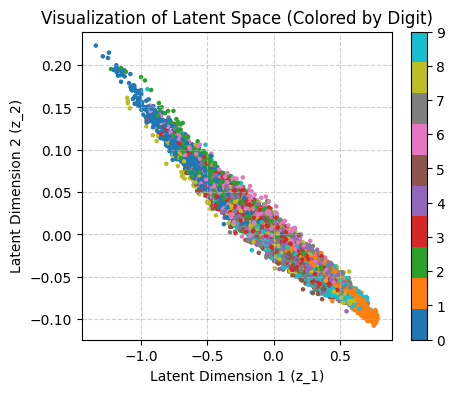

In [ ]:
# We will use our best model: encoder_d3
encoder_d4.eval() # Set the model to evaluation mode

# We need the test data for this visualization
# We can use the testset directly, which is not shuffled
test_loader = data.DataLoader(dataset=testset, batch_size=512, shuffle=False)

all_z_means = []
all_labels = []

# Use torch.no_grad() as we are not training
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)

        # Encode the batch to get the means
        z_means, _ = encoder_d3(x_batch)

        # Append results to our lists
        all_z_means.append(z_means.cpu()) # Move to CPU
        all_labels.append(y_batch.cpu())

# Concatenate all batches into single tensors
all_z_means = torch.cat(all_z_means, dim=0)
all_labels = torch.cat(all_labels, dim=0)

print(f"Encoded {len(all_labels)} test images.")

# Plot the 2D latent space
plt.figure(figsize=(5, 4))
scatter = plt.scatter(all_z_means[:, 0], all_z_means[:, 1], c=all_labels, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Latent Dimension 1 (z_1)")
plt.ylabel("Latent Dimension 2 (z_2)")
plt.title("Visualization of Latent Space (Colored by Digit)")
plt.show()